# IFN619. Week 8: Neural Networks and Fairness in Data Analytics

## Determining Flower Species

You've been contracted by a floral research company in Canada to assist with a dilemma they are facing concerning some uncertainty in their data.

You see, they recently held an expedition to count and characterise flowers in a nearby forest, to inform a local honey company on the yield and quality of flowers for the year. However, some of their papers were damaged during the expedition, causing the species types on certain records to be de-identified, and leaving only the measurements of the flowers behind.

Their management team is upset, considering that the expedition was expensive to fund, and they still need to submit the report to the honey company.

**They want to know if there is some way to confidently determine the flower species of the damaged records?**

In [77]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# keras / deep learning libraries
import numpy as np
import random as rn
import csv

# For reproduciability reasons:
np.random.seed(515)
rn.seed(515)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

# callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import pylab as pl
from pylab import savefig

plt.style.use('seaborn-deep')
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
# very important for feature transformation
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler

sns.set()

### The Dataset

They provide you with the dataset of the undamaged records. It appears that they were recording the measurements of the flower sizes to indicate the quality of the surveyed flowers. Perhaps we can use this data to inform an analysis that might provide some reassurance under the current uncertainty.

In [ ]:
# find the dataset "iris.csv" in the data folder
# try to identify what is the class variable and load the dataset

# YOUR CODE HERE
dataset_path = ...
class_var = ...
dataset = pd.read_csv( dataset_path )
dataset

### Checking Class Balance



Here, we're going to try to detect imbalances in the class labels. A classifier needs to have the same amount of instances for each class, otherwise it will be biased towards one of them

In [ ]:
# perform a group by operation and count how many instances you have from each class

# YOUR CODE HERE

### Checking How Features are Correlated and Distributed per Class

Here we visualise the correlation between features: the less correlated, the better. The main diagonal shows how each feature is correlated with itself for each class:

In [ ]:
# this can take a while to run
g = sns.pairplot(dataset, hue=class_var, palette="husl")

### Feature Transformation

In [ ]:
# get an array with the features names
# YOUR CODE GOES HERE
feature_names = 

# get an array with the unique class labels
# YOUR CODE GOES HERE
labels = 

# separate variables: 
# put all features in varible, X, which is a matrix
# and all the class labels in variable y, which is an array
# YOUR CODE GOES HERE
X = 
y = 

# general info about number of features and classes
# YOUR CODE GOES HERE
n_features = 
n_samples = 
n_classes = 

print("There are a total of %d training instances, %d features and a total of %d classes\n" %(n_samples, n_features, n_classes))

In [ ]:
# taking a look at our features (also called the independent variables)
X[0:10,:]

In [ ]:
# taking a look at the class variable (also called the dependent variable)
y[0:10]

In [ ]:
# taking a look at the unique class labels
labels

In [ ]:
# create numerical encoding for attribute species
# each class will be in one neuron, one column in a matrix
# 'setosa' - index 0
# 'versicolor' - index 1 
# 'virginica' - index 2

# YOUR CODE GOES HERE. Use one hot encoder
enc = 
Y = 
Y[0:10,:]

In [18]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# taking a look

X_scaled[0:10,:]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ]])

### Training Process

#### Split Data

In [19]:
# Split the data set into training, test and validation set
# use random state flag 2

# YOUR CODE HERE
X_train, X_test, Y_train, Y_test = 
X_validation, X_test, Y_validation, Y_test = 


#### Looking for the best NN architecture and params

Some hints.

The number of neurons in the hidden layer(s) also will involve trial and error but there are some popular cheat sheets floating around for choosing number of neurons in a hidden layer, such as the following:

$ N_h = \frac{N_s}{ \alpha (N_i + N_o)  }$

Nh is the number of neurons in the hidden layer; 
Ns is the number of samples in the training data;
alpha is the scaling factor, 
Ni is the number of input neurons
No is the number of output neurons.

### Auxiliary functions

#### Create a general NN model

In [79]:
# create neural network
def create_model(input_dim, output_dim, nodes, hidden_layers=1, loss_func='categorical_crossentropy', optim='nadam', metrics=['accuracy'], name='model'):
    
    model = Sequential(name=name)

    # adding a sequence of layers according to the fucntion's input params
    model.add( Dense(nodes, input_dim=input_dim, activation='relu'))  # input layer
    for i in range(hidden_layers):                                    # hidden layers
        model.add(Dense(nodes, activation='relu'))  
    model.add(Dense(output_dim, activation='softmax'))                # output layer

    # Compile model
    if( optim == "nadam" ):
        optim = keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)
  
    model.compile(loss=loss_func, optimizer=optim, metrics=metrics)
    return model


#### Saving and Loading Trained Models

In [80]:
# SERIALIZE_MODEL ------------------------------------------
def serialize_model( model, model_name, path ):
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(path + model_name+"_DUO.json", "w") as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    model.save_weights( path + model_name+"_DUO.h5")
    print("Model saved to disk") 

# SERIALIZE_MODEL_HISTORY ------------------------------------------
def serialize_model_history(  model_hist, model_name, path ):
    file = open(path + model_name + "_hist.csv", "w")
    w = csv.writer( file )
    
    for key, val in model_hist.history.items():
        w.writerow([key, val])
    file.close()
    print("Model history saved to disk") 

# LOAD_MODEL_HISTORY ------------------------------------------
def load_model_history( model_name, path):
    
    model_hist_loaded = {}
    values = []
    
    # load dictionary
    r = open( path + model_name + "_hist.csv", "r").read()
    for line in r.split("\n"):
        if(len(line) == 0):
            continue
            
        metric = line.split(",\"[")[0]                                    # extract metrics
        values_str = line.split(",\"[")[1].replace("]\"","").split(", ")  # extract validation values
        values = [float(val_str) for val_str in values_str]
        model_hist_loaded.update( {metric : values} )
    return model_hist_loaded

# LOAD_MODEL ------------------------------------------
def load_model( model_name, path ):
    json_file = open( path + model_name +  "_DUO.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    # load weights into new model
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(path + model_name +  "_DUO.h5")
    print("Loaded model from disk")
    return loaded_model

#### Plot Learning Curves

In [81]:
# plot training curves
def plot_training_curve(history):
    
    f, axarr = plt.subplots(1,2)
    f.set_figheight(5)
    f.set_figwidth(10)

    axarr[0].plot(history['loss'], label='train')
    axarr[0].plot(history['val_loss'], label='val')
    axarr[0].set_ylabel('loss', fontsize=12)
    axarr[0].set_xlim(0,150)
    axarr[0].set_xlabel('iterations', fontsize=12)

    axarr[1].plot(history['accuracy'], label='train')
    axarr[1].plot(history['val_accuracy'], label='val')
    axarr[1].set_ylabel('accuracy', fontsize=12)
    axarr[1].set_xlabel('iterations', fontsize=12)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Looking for the best models: Grid Search

We will create a list of different models with different numbers of hidden layers and neurons

In [82]:
MAX_NODES = 12
MAX_HLAYERS = 4
DEBUG = False
models = []
metrics = ['accuracy']

# DEFINE DIFFERENT MODELS WITH DIFFERENT NUMBER OF HIDDEN LAYERS
# AND DIFFERENT NUMBER OF NEURONS
for neuron in range(4, MAX_NODES+1):
    print("-----------------------------------")
    for hidden_layer in range(1, MAX_HLAYERS+1):
        model_name = "model_h" + str(hidden_layer) + "_N"+str(neuron)
        model = create_model(n_features, n_classes, neuron, hidden_layer, name=model_name, metrics = metrics)
        
        print("Generating model: " + model_name)
        models.append( model )
        
    # plot general information for each model
    if( DEBUG ):  
        for model in models:
            model.summary()

-----------------------------------
Generating model: model_h1_N4
Generating model: model_h2_N4
Generating model: model_h3_N4
Generating model: model_h4_N4
-----------------------------------
Generating model: model_h1_N5
Generating model: model_h2_N5
Generating model: model_h3_N5
Generating model: model_h4_N5
-----------------------------------
Generating model: model_h1_N6
Generating model: model_h2_N6
Generating model: model_h3_N6
Generating model: model_h4_N6
-----------------------------------
Generating model: model_h1_N7
Generating model: model_h2_N7
Generating model: model_h3_N7
Generating model: model_h4_N7
-----------------------------------
Generating model: model_h1_N8
Generating model: model_h2_N8
Generating model: model_h3_N8
Generating model: model_h4_N8
-----------------------------------
Generating model: model_h1_N9
Generating model: model_h2_N9
Generating model: model_h3_N9
Generating model: model_h4_N9
-----------------------------------
Generating model: model_h1_N

In [29]:
# DO NOT RUN THIS CELL FOR THE PURPOSES OF THIS TUTORIAL
# This piece of code performs a grid search,
# It trains different models so we can analyse the different learning curves
# and choose which one performs better

FLAG = False # only set true if you want to run the grid search process
# not recommended to do over the tutorial
# the idea is for you to find the best models and upload them with your Jupyter
# notebook so we do not have to run this expensive process

# you can find the pre-trained models in this folder
# together with their respective training history
models_path = "./tutorial_trained_models/"

# START THE GRID SEARCH
EPOCHS = 150
BATCH_SIZE = 1

HISTORY_DICT = {}

if FLAG:
    patience = 10 # how many iterations to be considered a convergence

    # define the callebacks to take into consideration during training
    # stop training when convergence is achieved after 10 iterations
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min')
    # save the model after every epoch
    callbacks_list = [early_stop]
    
    # grid search over each model
    for model in models:
        print('MODEL NAME:', model.name)
        history_callback = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                                 verbose=0, validation_data=(X_validation, Y_validation), callbacks=callbacks_list)
        
        score_test = model.evaluate( X_test, Y_test, verbose=0 )
        score_train = model.evaluate( X_train, Y_train  )
        
        print('Test loss:     ', format(score_test[0], '.4f'), '\tTrain loss: ', format(score_train[0], '.4f') )
        print('Test accuracy: ', format(score_test[1], '.4f'), '\tTrain accu: ', format(score_train[1], '.4f') )
        print('Abs accuracy:  ', format( np.abs( score_test[1] - score_train[1] ), '.4f'))
        print('Abs loss:      ', format( np.abs( score_test[0] - score_train[0] ), '.4f'))
        print('\n###########################################################\n')

        HISTORY_DICT[model.name] = [history_callback, model]
        
        # save the model to a file, so we do not have to run the Grid Search function again
        # serialize best model to JSON and weights to HDF5
        serialize_model( model, model.name, models_path )
        
        # serialize best model training history to CSV
        serialize_model_history( history_callback, model.name, models_path )

MODEL NAME: model_h1_N4
4/4 [==============================] - 0s 1ms/step - loss: 0.4961 - accuracy: 0.6667
Test loss:      0.4493 	Train loss:  0.4961
Test accuracy:  0.6087 	Train accu:  0.6667
Abs accuracy:   0.0580
Abs loss:       0.0468

###########################################################

Model saved to disk
Model history saved to disk
MODEL NAME: model_h2_N4
Epoch 00012: early stopping
4/4 [==============================] - 0s 1ms/step - loss: 1.0981 - accuracy: 0.3524
Test loss:      1.1013 	Train loss:  1.0981
Test accuracy:  0.2174 	Train accu:  0.3524
Abs accuracy:   0.1350
Abs loss:       0.0032

###########################################################

Model saved to disk
Model history saved to disk
MODEL NAME: model_h3_N4
Epoch 00011: early stopping
4/4 [==============================] - 0s 1ms/step - loss: 1.0981 - accuracy: 0.3524
Test loss:      1.1014 	Train loss:  1.0981
Test accuracy:  0.2174 	Train accu:  0.3524
Abs accuracy:   0.1350
Abs loss:       0.

Looking at the general training process, we need to choose the model with the best trade off in terms of validation accuracy vs train accuracy and validation loss and train loss

If accuracy in train data is much higher than the accuracy in the validation set, then it means the algorithm learned "by heart" and was not able to generalize this is called overfitting and it is very typical in machine learning

Ideally, we want the validation curve and the training curve as close to  each other as possible

Remember the loss function is the "cost of error" of the model.  The goal is to have the loss converging to zero and the maximum possible accuracy

In [ ]:
# take a look at ALL LEARNING CURVES of the trained models
# choose the MODEL NAME of a good performing model
# and a bad performing model
# do a FOR LOOP over all MODELS, extract the model name of each model
# load the model
# load the model history
# plot the learning curves and the model architecture

# YOUR CODE GOES HERE
for m in models:
    ...

#### Choose two models: one that performs very well and one that performs badly

In [83]:
# YOUR CODE GOES HERE

# BEST MODEL
best_model_name = 

# let's also take a look at a BAD MODEL
bad_model_name = 

#### Loading Models

In [ ]:
# load a good model and training history
best_model_hist_loaded = load_model_history( best_model_name, models_path )
best_model_loaded = load_model( best_model_name,  models_path )
print(best_model_loaded.summary())

In [ ]:
# load a bad model and training history
# YOUR CODE GOES HERE


#### Evaluate the Good Model

In [ ]:
# evaluate the BEST loaded model on test and training data
print("EVALUATING BEST MODEL:")
optim = keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)
best_model_loaded.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

train_loss,train_acc= best_model_loaded.evaluate(X_train, Y_train, verbose=1)
test_loss,test_acc = best_model_loaded.evaluate(X_test, Y_test, verbose=1)
print('[Accuracy] Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('[Loss] Train: %.3f, Test: %.3f' % (train_loss, test_loss))

In [ ]:
# evaluate the BAD loaded model on test and training data
# YOUR CODE GOES HERE
print("EVALUATING BAD MODEL:")
...


In [ ]:
# get model's training history
plt.plot(best_model_hist_loaded['accuracy'], label='train')
plt.plot(best_model_hist_loaded['val_accuracy'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.plot(best_model_hist_loaded['loss'], label='train')
plt.plot(best_model_hist_loaded['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

#### Evaluate the Bad Model

In [ ]:
# get model's training history
# YOUR CODE GOES HERE

...

#### Can you discuss what happened in these models?

**Answer**

### Analysing the Confusion Matix of the Good Model

In [71]:
# how to convert predictions into their original classes
predictions = enc.inverse_transform(best_model_loaded.predict( X_test ))

print("Before transformation")
print(best_model_loaded.predict( X_test )[0:10])
print("\nAfter transformation\n")
print(predictions[0:10])


Before transformation
[[1.6016900e-03 9.5532757e-01 4.3070827e-02]
 [2.1289354e-03 9.6037835e-01 3.7492719e-02]
 [1.6721595e-02 9.6615893e-01 1.7119484e-02]
 [6.5328606e-04 9.1016328e-01 8.9183502e-02]
 [9.9819154e-01 1.8075722e-03 9.5725716e-07]
 [1.8463275e-06 1.8140510e-01 8.1859308e-01]
 [9.9784601e-01 2.1525400e-03 1.4345661e-06]
 [9.9875569e-01 1.2437961e-03 4.3138255e-07]
 [9.9824643e-01 1.7525216e-03 1.0185709e-06]
 [3.4649156e-07 3.4601383e-02 9.6539825e-01]]

After transformation

[['versicolor']
 ['versicolor']
 ['versicolor']
 ['versicolor']
 ['setosa']
 ['virginica']
 ['setosa']
 ['setosa']
 ['setosa']
 ['virginica']]


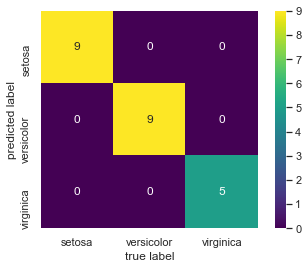

In [72]:
from sklearn.metrics import confusion_matrix
from matplotlib import cm

groundtruth = enc.inverse_transform( Y_test )

mat = confusion_matrix(groundtruth, predictions)
sns.heatmap(mat.T, square=True, cbar=True, xticklabels=labels, \
            yticklabels=labels, annot=True, cmap=cm.viridis)

plt.xlabel('true label')
plt.ylabel('predicted label');

### Analysing the Confusion Matix of the Bad Model

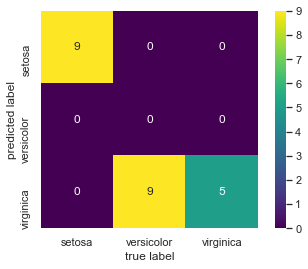

In [73]:
# how to convert predictions into their original classes
predictions_bad_model = enc.inverse_transform(bad_model_loaded.predict( X_test ))
groundtruth = enc.inverse_transform( Y_test )

mat = confusion_matrix(groundtruth, predictions_bad_model)
sns.heatmap(mat.T, square=True, cbar=True, xticklabels=labels, \
            yticklabels=labels, annot=True, cmap=cm.viridis)

plt.xlabel('true label')
plt.ylabel('predicted label');

#### Can you interpret this?

Maybe it is better to take a look at the predictions of the bad model

In [ ]:
predictions_bad_model

In [ ]:
groundtruth

### Ethical discussions about the approach as in the lecture